In [ ]:
!pip install sastrawi
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!rm -rf idonesian_tourism/
!kaggle datasets download -d aprabowo/indonesia-tourism-destination -p /content/dataset --unzip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 68.6MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.colors import LinearSegmentedColormap
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity
from io import BytesIO
import base64
import statsmodels.api as sm # Add this import to your existing imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# ⭐ Data Understanding ⭐

# Place Tourism

| Nama Kolom | Tipe Data | Deskripsi |
|---|---|---|
| Place_Id | int64 | ID unik untuk setiap tempat |
| Place_Name | object | Nama tempat wisata |
| Description | object | Deskripsi tempat |
| Category | object | Kategori tempat (misalnya, Alam, Budaya) |
| City | object | Kota tempat wisata berada |
| Price | float64 | Harga atau biaya masuk |
| Rating | float64 | Rating rata-rata tempat |
| Time_Minutes | float64 | Estimasi waktu kunjungan |
| Coordinate | object | Koordinat latitude dan longitude |
| Lat | float64 | Koordinat latitude |
| Long | float64 | Koordinat longitude |

### Reading Data

In [ ]:
place_tourism = pd.read_csv('/content/dataset/tourism_with_id.csv')
place_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


### Assesing Data

In [ ]:
print("Bentuk Data :", place_tourism.shape)
print(10*"=")
# Data information
print("Informasi pada setiap Kolom pada dataset place_toursim :")
place_tourism.info()
print(10*"=")
# Data Duplicated
print("Jumlah Duplikat Data :")
place_tourism.duplicated().sum()
# Data Null
print("Jumlah Null Data :")
place_tourism.isna().sum()

Bentuk Data : (437, 13)
Informasi pada setiap Kolom pada dataset place_toursim :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB
Jumlah Duplikat Data :
Jumlah Null Data :


,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [ ]:
print("Jumlah Unique Data :")
place_tourism.nunique()

Jumlah Unique Data :


,0
Place_Id,437
Place_Name,437
Description,437
Category,6
City,5
Price,50
Rating,14
Time_Minutes,15
Coordinate,437
Lat,437


Dari hasil assessing data pada dataset **`place_tourism`** diperoleh bahwa :

- Tidak ada data duplikasi pada dataset
- Terdapat missing value pada kolom Time Minutes sebanyak 232 dan Unnamed :11 sebanyak 437. sehingga perlu dilakukan cleaning  

# Rating

### Reading Data

In [ ]:
rating = pd.read_csv('/content/dataset/tourism_rating.csv')
rating.head(3)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


### Assesing Data

In [ ]:
print("Bentuk Data :", rating.shape)
print(10*"=")
# Data information
print("Informasi pada setiap Kolom pada dataset place_toursim :")
rating.info()
print(10*"=")
# Data Duplicated
print("Jumlah Duplikat Data :")
rating.duplicated().sum()
# Data Null
print("Jumlah Null Data :")
rating.isna().sum()

Bentuk Data : (10000, 3)
Informasi pada setiap Kolom pada dataset place_toursim :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB
Jumlah Duplikat Data :
Jumlah Null Data :


,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [ ]:
print("Jumlah Unique Data :")
rating.nunique()

Jumlah Unique Data :


,0
User_Id,300
Place_Id,437
Place_Ratings,5


Pada dataset Rating, diketahui bahwa raw data sebanyak 10000 dan memiliki 3 variabel `User_id`, `place_id` dan `Place_Ratings` tidak memiliki missing value dan  tidak memiliki data yang duplikat

# User

### Reading Data

In [ ]:
user = pd.read_csv('/content/dataset/user.csv')
user.head(3)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23


### Assesing Data

In [ ]:
print("Bentuk Data :", user.shape)
print(10*"=")
# Data information
print("Informasi pada setiap Kolom pada dataset place_toursim :")
user.info()
print(10*"=")
# Data Duplicated
print("Jumlah Duplikat Data :")
user.duplicated().sum()
# Data Null
print("Jumlah Null Data :")
user.isna().sum()

Bentuk Data : (300, 3)
Informasi pada setiap Kolom pada dataset place_toursim :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB
Jumlah Duplikat Data :
Jumlah Null Data :


,0
User_Id,0
Location,0
Age,0


Dataset user memiliki 300 baris dan 3 kolom. Dataset ini tidak memiliki duplicated data dan tidak memiliki missing value

# ⭐ Data Preprocessing ⭐

## Handling Missing Value in Dataset Place Tourism

In [ ]:
place_tourism.isnull().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [ ]:
# Imputation to Time_Minutes column
place_tourism['Time_Minutes'] = place_tourism['Time_Minutes'].fillna(place_tourism['Time_Minutes'].mean())

In [ ]:
print("Setelah Dilakukan Filling Missing Value")
place_tourism.isnull().sum()

Setelah Dilakukan Filling Missing Value


,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,0
Coordinate,0
Lat,0


In [ ]:
place_tourism.head(4)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.000000,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.000000,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.000000,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,82.609756,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4


## Menghilangkan Kolom yang Tidak Diinginkan

In [ ]:
place_tourism.drop(['Unnamed: 11', 'Unnamed: 12'], axis=1, inplace=True)

In [ ]:
place_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.000000,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.000000,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.000000,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,82.609756,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.000000,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [ ]:
# Save Cleaned Data of place_tourism
place_tourism.to_csv('place_tourism_clean.csv', index=False)

# ⭐ Exploratory Data Analysis ⭐

## Univariate EDA on **place_tourism** dataset

In [ ]:
place_tourism

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.000000,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.000000,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.000000,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,82.609756,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.000000,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.000000,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,82.609756,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.000000,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,82.609756,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


### Place Name
Ada berapa lokasi wisata dalam dataset?

In [ ]:
print("Total lokasi wisata :",place_tourism['Place_Name'].nunique())

Total lokasi wisata : 437


### Category
Ada berapa lokasi wisata dalam dataset?

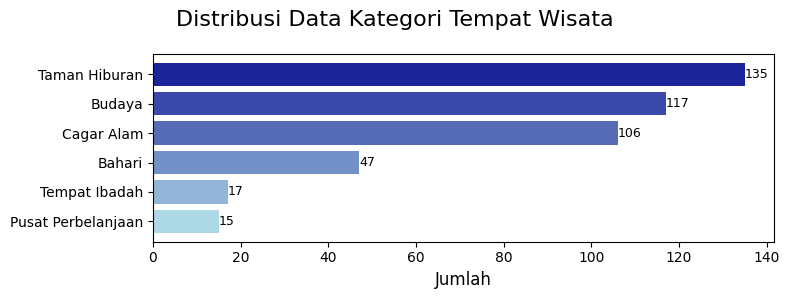

In [ ]:
gradient_blue = LinearSegmentedColormap.from_list("gradient_blue", ["#add8e6", "#00008b"])
plt.figure(figsize=(8, 3))
category_counts = place_tourism['Category'].value_counts().sort_values(ascending=True)

# Buat horizontal bar plot dengan gradient blue color
bars = plt.barh(
    category_counts.index,
    category_counts.values,
    color=gradient_blue([i / len(category_counts) for i in range(len(category_counts))])
)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             str(int(bar.get_width())),
             va='center',
             ha='left',
             fontsize=9,
             color='black')

plt.suptitle('Distribusi Data Kategori Tempat Wisata', fontsize=16)
plt.xlabel('Jumlah', fontsize=12)
#plt.ylabel('Kategori', fontsize=12)

# Sesuaikan layout dan tampilkan
plt.tight_layout()
plt.show()

Pada distribusi Data Kategori tempat Wisata, **Tempat Hiburan** menempati posisi teratassebanyak 135 kemudian disusul oleh **Budaya** sebesar 117. Adapun distribusi pada Kategori **Pusat Perbelanjaan** adalah sebanyak 15 yang menempati posisi terakhir

### City
Ada berapa lokasi kota wisata dalam dataset?

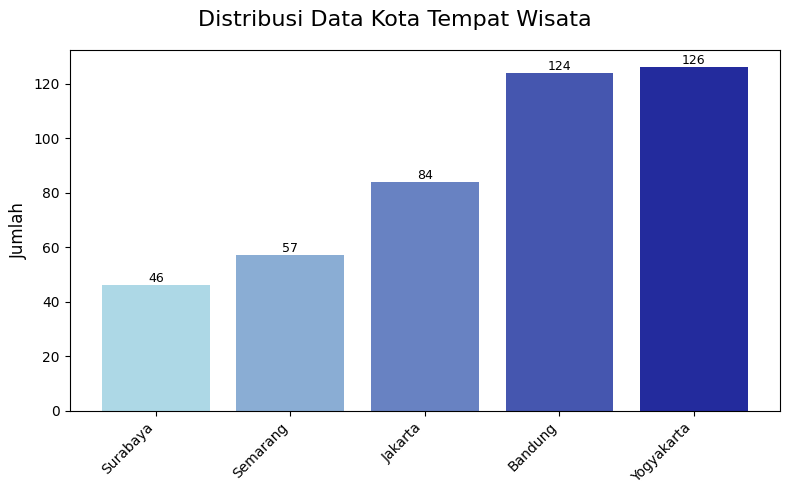

In [ ]:
gradient_blue = LinearSegmentedColormap.from_list("gradient_blue", ["#add8e6", "#00008b"])
plt.figure(figsize=(8, 5))  # Ubah figsize untuk tampilan yang lebih baik
city_counts = place_tourism['City'].value_counts().sort_values(ascending=True)

# Buat vertical bar plot dengan gradient blue color
bars = plt.bar(
    city_counts.index,  # Kota di sumbu x
    city_counts.values,  # Jumlah di sumbu y
    color=gradient_blue([i / len(city_counts) for i in range(len(city_counts))])
)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())),
             va='bottom',
             ha='center',
             fontsize=9,
             color='black')

plt.suptitle('Distribusi Data Kota Tempat Wisata', fontsize=16)
#plt.xlabel('Kota', fontsize=12)  # Label sumbu x
plt.ylabel('Jumlah', fontsize=12)  # Label sumbu y

# Rotasi label sumbu x agar mudah dibaca
plt.xticks(rotation=45, ha='right')

# Sesuaikan layout dan tampilkan
plt.tight_layout()
plt.show()

**Yogyakarta** memiliki jumlah terbanyak sebesar 126, selisih 2 dengan **Bandung** yang sebesar 124. Kemudian **Surabaya** menjadi yang terakhir sebesar 46 saja

### Pesebaran harga
Persebaran Data harga Pada wisata

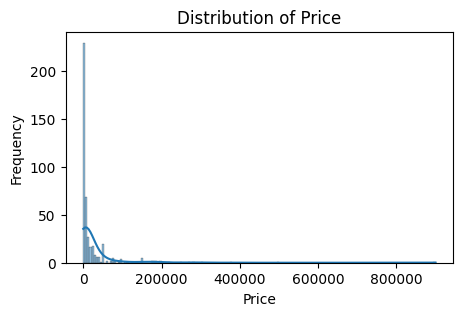

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(place_tourism['Price'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Sebagian besar tempat wisata memiliki harga yang rendah atau gratis. Hal ini terlihat dari tingginya frekuensi pada rentang harga 0 hingga sekitar 25000.

### Rating

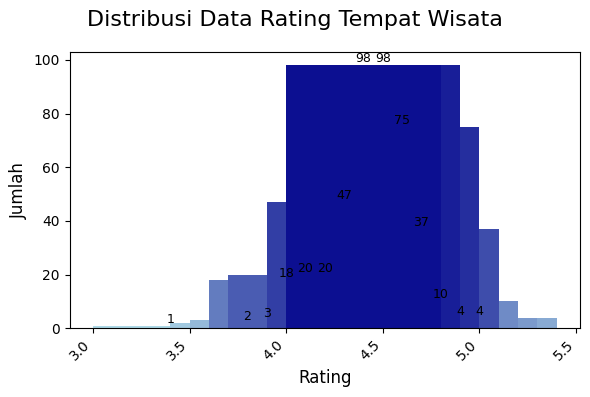

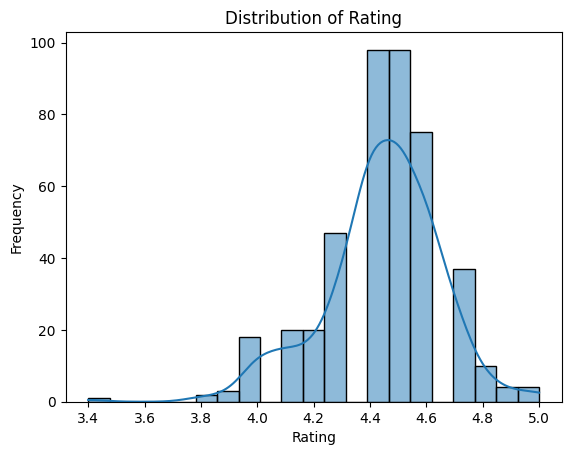

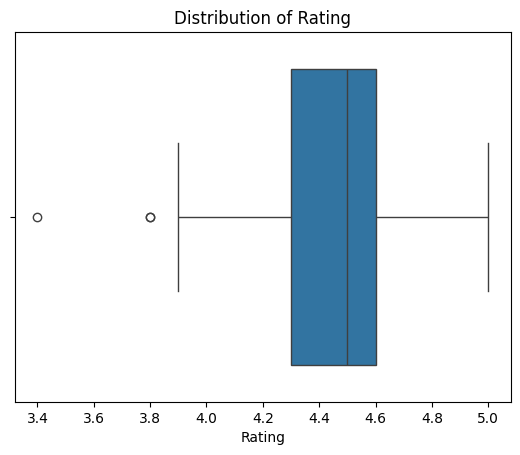

In [ ]:
gradient_blue = LinearSegmentedColormap.from_list("gradient_blue", ["#add8e6", "#00008b"])
plt.figure(figsize=(6, 4))
rating_counts = place_tourism['Rating'].value_counts().sort_values(ascending=True)

# Buat vertical bar plot dengan gradient blue color
bars = plt.bar(
    rating_counts.index,
    rating_counts.values,
    color=gradient_blue([i / len(rating_counts) for i in range(len(rating_counts))])
)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())),
             va='bottom',
             ha='center',
             fontsize=9,
             color='black')

plt.suptitle('Distribusi Data Rating Tempat Wisata', fontsize=16)
plt.xlabel('Rating', fontsize=12)  # Label sumbu x
plt.ylabel('Jumlah', fontsize=12)  # Label sumbu y

# Rotasi label sumbu x agar mudah dibaca
plt.xticks(rotation=45, ha='right')

# Sesuaikan layout dan tampilkan
plt.tight_layout()
plt.show()

import seaborn as sns

sns.histplot(place_tourism['Rating'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(x='Rating', data=place_tourism)
plt.title('Distribution of Rating')
plt.show()


## Univariate EDA on **Rating**

In [ ]:
rating

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


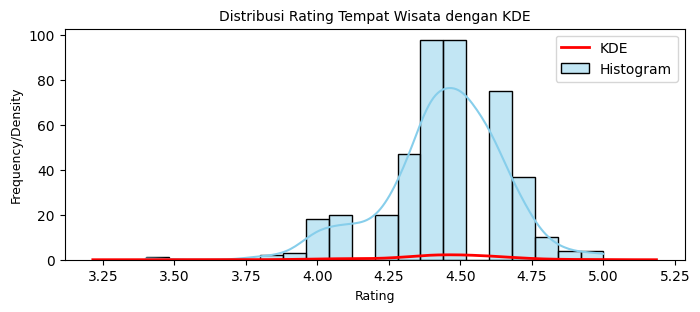

In [ ]:
plt.figure(figsize=(8, 3))
sns.histplot(place_tourism['Rating'], kde=True, bins=20, color='skyblue', label='Histogram')
sns.kdeplot(place_tourism['Rating'], color='red', linewidth=2, label='KDE')
plt.title('Distribusi Rating Tempat Wisata dengan KDE', fontsize=10)
plt.xlabel('Rating', fontsize=9)
plt.ylabel('Frequency/Density', fontsize=9)
plt.legend()
plt.show()

Berdasarkan grafik distribusi rating tempat wisata dengan KDE, terlihat bahwa sebagian besar tempat wisata mendapatkan rating di rentang 4.0 hingga 4.5. Hal ini menunjukkan bahwa mayoritas tempat wisata di dataset tersebut memiliki kualitas yang baik dan memuaskan bagi pengunjung. Puncak distribusi KDE berada di sekitar rating 4.2, yang mengindikasikan bahwa rating tersebut merupakan rating yang paling umum diberikan oleh pengguna. Selain itu, distribusi rating cenderung condong ke kanan (right-skewed), yang berarti terdapat beberapa tempat wisata dengan rating yang sangat tinggi, meskipun jumlahnya relatif sedikit. Secara keseluruhan, distribusi rating tempat wisata menunjukkan bahwa mayoritas tempat wisata memiliki kualitas yang baik dan memuaskan bagi pengunjung, dengan beberapa tempat wisata yang memiliki rating sangat tinggi.

## Univariate EDA on **User**

In [ ]:
user

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20
...,...,...,...
295,296,"Lampung, Sumatera Selatan",31
296,297,"Palembang, Sumatera Selatan",39
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27


### Location
Analisis persebaran lokasi

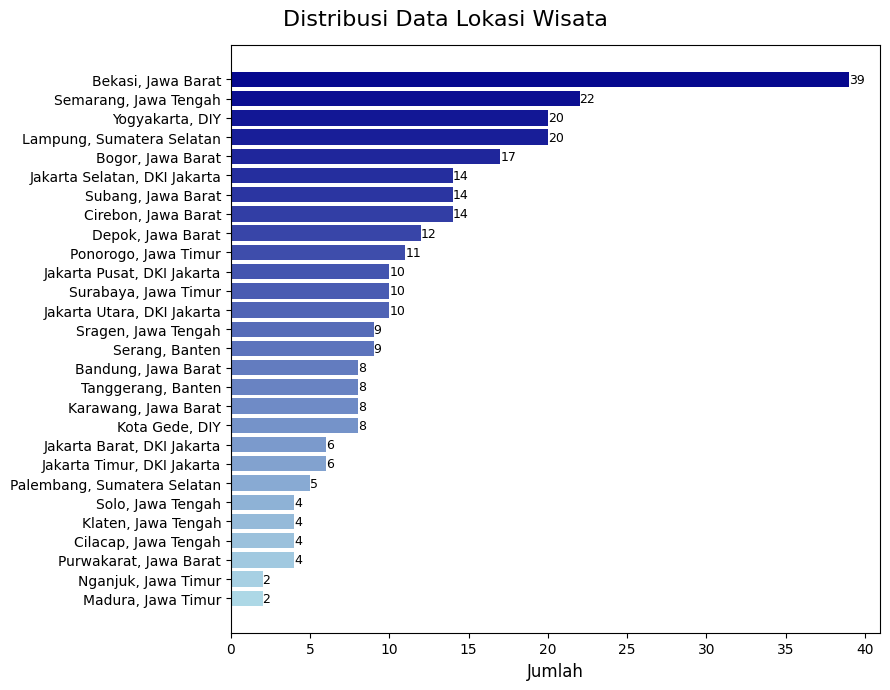

In [ ]:
gradient_blue = LinearSegmentedColormap.from_list("gradient_blue", ["#add8e6", "#00008b"])
plt.figure(figsize=(9, 7))
location_counts = user['Location'].value_counts().sort_values(ascending=True)

# Buat horizontal bar plot dengan gradient blue color
bars = plt.barh(
    location_counts.index,
    location_counts.values,
    color=gradient_blue([i / len(location_counts) for i in range(len(location_counts))])
)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             str(int(bar.get_width())),
             va='center',
             ha='left',
             fontsize=9,
             color='black')

plt.suptitle('Distribusi Data Lokasi Wisata', fontsize=16)
plt.xlabel('Jumlah', fontsize=12)
#plt.ylabel('Lokasi', fontsize=12)

# Sesuaikan layout dan tampilkan
plt.tight_layout()
plt.show()

Berdasarkan visualisasi data, terlihat bahwa lokasi wisata terbanyak berada di Jakarta, diikuti oleh Bogor dan Bandung. Jumlah lokasi wisata di Jakarta jauh lebih banyak dibandingkan dengan kota-kota lainnya dalam dataset. Sebaliknya, lokasi wisata paling sedikit berada di Yogyakarta, Surabaya, dan Malang. Hal ini mengindikasikan bahwa Jakarta merupakan pusat wisata yang populer, sementara kota-kota seperti Yogyakarta, Surabaya, dan Malang mungkin memiliki daya tarik wisata yang lebih sedikit atau kurang dikenal oleh pengguna dalam dataset.

### Age

Rentang usia pengunjung

.: Age Column Skewness & Kurtosis :.
****************************************
Skewness: 0.008
Kurtosis: -1.058




/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


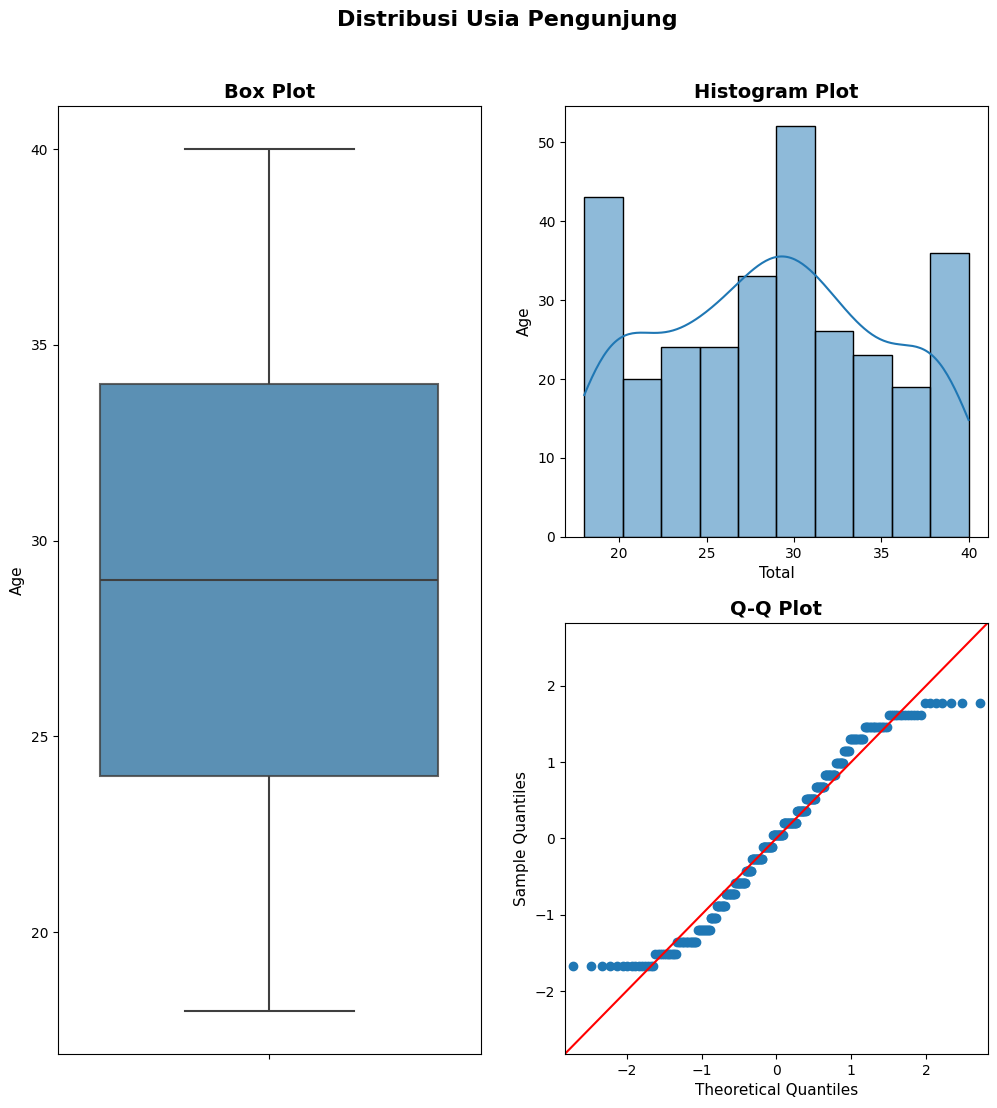

In [ ]:
# --- Variable, Color & Plot Size ---
var = 'Age'
fig = plt.figure(figsize=(12, 12))

# --- Skewness & Kurtosis ---
print('\033[1m'+'.: Age Column Skewness & Kurtosis :.'+'\033[0m')
print('*' * 40)
print('Skewness:'+'\033[1m {:.3f}'.format(user[var].skew(axis=0, skipna=True)))
print('\033[0m'+'Kurtosis:'+'\033[1m {:.3f}'.format(user[var].kurt(axis=0, skipna=True)))
print('\n')

# --- General Title ---
fig.suptitle('Distribusi Usia Pengunjung',
             fontweight='bold',
             fontsize=16,
             fontfamily='sans-serif')
fig.subplots_adjust(top=0.9)

# --- Histogram ---
ax_1 = fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot',
          fontweight='bold',
          fontsize=14,
          fontfamily='sans-serif')

sns.histplot(data=user,
             x=var,
             kde=True)

plt.xlabel('Total',
           fontweight='regular',
           fontsize=11,
           fontfamily='sans-serif')

plt.ylabel('Age',
           fontweight='regular',
           fontsize=11,
           fontfamily='sans-serif')

# --- Q-Q Plot ---
ax_2 = fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot',
          fontweight='bold',
          fontsize=14,
          fontfamily='sans-serif')

sm.qqplot(user[var],
       fit=True,
       line='45',
       ax=ax_2,
       color='#BA1141')

plt.xlabel('Theoretical Quantiles',
           fontweight='regular',
           fontsize=11,
           fontfamily='sans-serif')

plt.ylabel('Sample Quantiles',
           fontweight='regular',
           fontsize=11,
           fontfamily='sans-serif')

# --- Box Plot ---
ax_3 = fig.add_subplot(1, 2, 1)
plt.title('Box Plot', fontweight='bold', fontsize=14, fontfamily='sans-serif')
sns.boxplot(data=user, y=var, boxprops=dict(alpha=0.8), linewidth=1.5)
plt.ylabel('Age', fontweight='regular', fontsize=11, fontfamily='sans-serif')

plt.show()


Berdasarkan analisis distribusi usia pengunjung, diketahui bahwa mayoritas pengunjung berusia antara 20 hingga 30 tahun. Distribusi data usia cenderung terdistribusi normal dengan sedikit kemiringan ke kanan (right-skewed), mengindikasikan adanya beberapa pengunjung dengan usia yang lebih tua. Meskipun terdapat outlier pada data usia, namun secara umum dapat disimpulkan bahwa tempat wisata tersebut lebih banyak dikunjungi oleh kalangan muda. Hal ini dapat menjadi pertimbangan dalam strategi pemasaran dan pengembangan produk wisata yang disesuaikan dengan preferensi dan kebutuhan pengunjung dari rentang usia tersebut.

# ⭐ Data Preparation : Content-Based Filtering⭐

Pada tahap ini, dataset place_tourism dan rating akan digabungkan untuk pemodelan content-based filtering. sehingga hanya beberapa kolom saja yang akan digunakan dalam dataset

## Feature Selection for Place_tourism

In [ ]:
place_tourism.drop(['Rating','Time_Minutes','Coordinate','Lat','Long'],axis=1,inplace=True)
place_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000


## Menggabungkan Data Place_Tourism dengan Rating

In [ ]:
merged_data = pd.merge(rating.groupby('Place_Id')['Place_Ratings'].mean(),
                       place_tourism,
                       on='Place_Id')
merged_data

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...,...
432,433,3.304348,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,2.400000,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,3.000000,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,3.090909,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


In [ ]:
# Membuat Copy Data
data_content_based = merged_data.copy()
data_content_based

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...,...
432,433,3.304348,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,2.400000,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,3.000000,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,3.090909,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


## Text Processing

Menyesuaikan data untuk persiapan content-based Filtering

In [ ]:
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    return data

In [ ]:
# Menyatukan Deskripsi dan Kategori ke dalam kolom Pattern
data_content_based['Pattern'] = data_content_based['Description'] + ' ' + data_content_based['Category']
# Menghilangkan kolom Price, Place Rating, Deskripsi, dan City
data_content_based.drop(['Price','Place_Ratings','Description','City'],axis=1,inplace=True)

data_content_based

,Place_Id,Place_Name,Category,Pattern
0,1,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...
1,2,Kota Tua,Budaya,"Kota tua di Jakarta, yang juga bernama Kota Tu..."
2,3,Dunia Fantasi,Taman Hiburan,Dunia Fantasi atau disebut juga Dufan adalah t...
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Taman Mini Indonesia Indah merupakan suatu kaw...
4,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...
...,...,...,...,...
432,433,Museum Mpu Tantular,Budaya,Museum Negeri Mpu Tantular adalah sebuah museu...
433,434,Taman Bungkul,Taman Hiburan,Taman Bungkul adalah taman wisata kota yang te...
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan,Air mancur menari atau dancing fountain juga a...
435,436,Taman Flora Bratang Surabaya,Taman Hiburan,Taman Flora adalah salah satu taman kota di Su...


In [ ]:
# Menerapkan Function
data_content_based['Pattern'] = data_content_based['Pattern'].apply(preprocessing)
data_content_based

,Place_Id,Place_Name,Category,Pattern
0,1,Monumen Nasional,Budaya,monumen nasional populer singkat monas tugu mo...
1,2,Kota Tua,Budaya,kota tua jakarta juga nama kota tua pusat alun...
2,3,Dunia Fantasi,Taman Hiburan,dunia fantasi sebut dufan tempat hibur letak k...
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,taman mini indonesia indah rupa suatu kawasan ...
4,5,Atlantis Water Adventure,Taman Hiburan,atlantis water adventure kenal atlantis ancol ...
...,...,...,...,...
432,433,Museum Mpu Tantular,Budaya,museum negeri mpu tantular buah museum negeri ...
433,434,Taman Bungkul,Taman Hiburan,taman bungkul taman wisata kota letak pusat ko...
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan,air mancur tari dancing fountain ada kawasan j...
435,436,Taman Flora Bratang Surabaya,Taman Hiburan,taman flora salah satu taman kota surabaya rup...


# ⭐ Modeling Content-Based Filtering⭐

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tfidf.fit(data_content_based['Pattern'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['00', '000', '01', ..., 'zona', 'zoo', 'zuider'], dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(data_content_based['Pattern'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(437, 4962)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data_content_based.Pattern
).sample(22, axis=1).sample(10, axis=0)

,merah,simetris,asyik,inovasi,patramini,oktagonal,tinggi,pln,sabang,pimpin,...,basah,benih,industri,jamu,zeeland,undur,interaktif,rekonstruksi,administrasi,tumbuh
Pattern,,,,,,,,,,,,,,,,,,,,,
situs warungboto pesanggrahan rejawinangun salah satu bangun cagar budaya letak jalan veteran no 77 lurah warungboto camat umbulharjo kota yogyakarta daerah istimewa yogyakarta awal situs rupa lokasi buah pesanggrahan mandi taman hibur,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
plaza indonesia resmi awal tahun 1990 diri empat lantai toko kelas atas luas 38 050 m2 pusat belanja letak bundar hotel indonesia tepat antara jalan m h thamrin jalan kebon kacang raya kawasan bisnis utama jakarta nplaza indonesia lengkap hotel grand hyatt jakarta buah hotel bintang lima lantai 28 resmi buka pada awal tahun 1990 hotel milik lebih 300 kamar desain modern minimal restoran eksklusif fasilitas sangat lengkap npengembangan plaza indonesia lanjut entertainment x nter buka belah gedung ada bidik pangsa pasar anak muda gedung sambung buah jembatan keliling toko nkini plaza indonesia lengkap gedung kantor the plaza office tower apartement the keraton grand hyatt residences nplaza indonesia kembang pt global land development tbk nama pt kridaperdana indahgraha tbk pusat belanja,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
taman barunawati lokasi kota surabaya utara taman satu jadi referensi kunjung cukup recommended utama warga surabaya bahkan warga luar surabaya layak taman umum memang jadi tempat libur paling murah ada manfaat sendiri bisa rasa unjung pikir jadi tenang juga bisa ajak anak anggota keluarga kecil dar main playground ada dalam taman barunawati taman resmi 9 oktober 2019 itu sekarang kondisi nampak indah asri dapat alih perhati siapa lewat jalan perak barat surabaya kunjung taman tidak perlu rogoh kocek peser pun namun unjung masih dapat nikmat pandang semua fasilitas yang ada di dalam taman hibur,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kota tua jakarta juga nama kota tua pusat alun fatahillah alun ramai tunjuk rutin tari tradisional museum sejarah jakarta bangun era belanda lukis barang antik sedang museum wayang pamer boneka kayu khas jawa desa glodok chinatown kenal makan kaki lima pangsit mi goreng dekat sekunar kapal tangkap ikan labuh sunda kelapa kuno budaya,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pecenongan rupa salah satu surga kuliner jakarta pusat kenal sejak zaman jakarta nama kota batavia kawasan dapat dagang kaki lima jaja kuliner di pinggir jalan tahun tahun kawasan pecenongan makin ramai ada rumah makan-rumah makan mulai bangun kawasan pecenongan cocok kalian wisata kuliner malam hari agam jenis kuliner buat kamu bingung ingin coba mana lebih tak heran orang sudah pernah coba pergi kuliner sini pasti akan lagi pusat belanja,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jembatan merah rupa salah satu monumen sejarah surabaya jawa timur biar bagai jembatan jembatan jadi salah satu judul lagu cipta gesang masa zaman voc nilai penting jadi sarana hubung paling vital lewat kalimas tuju gedung karesidenan surabaya sudah bekas nkawasan jembatan merah rupa daerah niaga mulai kembang bagai akibat janji paku buwono ii mataram voc 11 november 1743 janji bagi daerah pantai utara masuk surabaya serah kuasa voc sejak surabaya ada sepenuh kuasa belanda kini posisi bagai pusat niaga terus langsung jembatan indikator ekonomi masuk salah satu plaza jembatan merah nperubahan fisik jadi sekitar tahun 1890-an pagar batas sungai ubah kayu jadi besi kini kondisi jembatan hubung jalan rajawali jalan kembang jepun sisi utara surabaya itu hampir sama persis jembatan beda warna merah budaya,0.321047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
taman bungkul taman wisata kota letak pusat kota s

## Cosine Similarity

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.04510993, 0.07188361, ..., 0.02304813, 0.01459437,
        0.00994663],
       [0.04510993, 1.        , 0.01922348, ..., 0.02402561, 0.01486861,
        0.0579609 ],
       [0.07188361, 0.01922348, 1.        , ..., 0.04484191, 0.08022609,
        0.0144817 ],
       ...,
       [0.02304813, 0.02402561, 0.04484191, ..., 1.        , 0.05645506,
        0.04562539],
       [0.01459437, 0.01486861, 0.08022609, ..., 0.05645506, 1.        ,
        0.11897411],
       [0.00994663, 0.0579609 , 0.0144817 , ..., 0.04562539, 0.11897411,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama tempat wisata
cosine_sim_df = pd.DataFrame(cosine_sim,
                             index=data_content_based['Place_Name'],
                             columns=data_content_based['Place_Name'])

print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap tempat wisata
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


Place_Name,Taman Keputran,Museum Tekstil,Plaza Indonesia,Taman Hiburan Rakyat,Museum Mandala Wangsit Siliwangi
Place_Name,,,,,
Goa Rong,0.047689,0.011410,0.018243,0.054230,0.039501
Taman Bunga Cihideung,0.078714,0.001982,0.011288,0.079258,0.037582
Kiara Artha Park,0.112509,0.047984,0.051299,0.132344,0.055840
Lembang Park & Zoo,0.022070,0.006420,0.038784,0.000000,0.001757
Jogja Exotarium,0.084819,0.011060,0.009357,0.064727,0.031139
Keraton Surabaya,0.054404,0.031013,0.058741,0.063695,0.061640
Panghegar Waterboom Bandung,0.052482,0.007948,0.015372,0.048339,0.018368
Museum Basoeki Abdullah,0.004338,0.074251,0.008484,0.024302,0.061003
Geoforest Watu Payung Turunan,0.030658,0.007173,0.003412,0.029528,0.018597


## Develop Content-Based Filtering Recommender System and Get Recommendation

In [ ]:
def recommend_by_content_based_filtering(nama_tempat, similarity_data=cosine_sim_df, items_data=data_content_based[['Place_Name','Pattern','Category']], k=10):
    """
    Recommends items using content-based filtering and returns a DataFrame.

    Args:
        nama_tempat (str): The name of the item to find recommendations for.
        similarity_data (DataFrame): The DataFrame containing the similarity matrix.
        items_data (DataFrame): The DataFrame containing the item data.
        k (int, optional): The number of recommendations to generate. Defaults to 10.

    Returns:
        DataFrame: A DataFrame containing the recommendations, or an empty DataFrame if the item is not found.
    """

    # Find the index of the given item
    filtered_items = items_data[items_data['Place_Name'] == nama_tempat]

    # Check if the item exists in the dataset
    if filtered_items.empty:
        print(f"Item '{nama_tempat}' not found in the dataset.")
        return pd.DataFrame()  # Return an empty DataFrame if item not found

    nama_tempat_index = filtered_items.index[0]

    # Get the similarity scores for the given item
    similarity_scores = similarity_data.iloc[nama_tempat_index]

    # Sort the items by similarity score in descending order
    nama_tempat_list = similarity_scores.sort_values(ascending=False).index[1:k + 1]

    # Create a DataFrame containing the recommendations
    recommended_items = items_data[items_data['Place_Name'].isin(nama_tempat_list)][['Place_Name', 'Category']]
    recommended_items['similarity_score'] = similarity_scores[nama_tempat_list].values

    return recommended_items

In [ ]:
# Skenario 1 : Candi Prambanan
recommend_by_content_based_filtering('Candi Prambanan')

,Place_Name,Category,similarity_score
85,Keraton Yogyakarta,Budaya,0.634871
103,Tebing Breksi,Budaya,0.553593
104,Candi Donotirto,Budaya,0.488287
110,Puncak Pinus Becici,Taman Hiburan,0.407251
169,Candi Borobudur,Budaya,0.305599
170,Candi Ijo,Budaya,0.222767
178,Candi Ratu Boko,Budaya,0.207963
192,Candi Sewu,Budaya,0.170799
334,Candi Gedong Songo,Budaya,0.096699
347,Pura Giri Natha,Budaya,0.096278


In [ ]:
# Case 2 : Museum Basoeki Abdullah
recommend_by_content_based_filtering('Museum Basoeki Abdullah')

,Place_Name,Category,similarity_score
19,Museum Taman Prasasti,Budaya,0.249897
20,Museum Wayang,Budaya,0.215493
23,Museum Nasional,Budaya,0.212838
40,Museum Bahari Jakarta,Budaya,0.209531
41,Museum Seni Rupa dan Kramik,Budaya,0.207353
73,Museum Tengah Kebun,Budaya,0.203953
88,De Mata Museum Jogja,Budaya,0.197842
117,Museum Sonobudoyo Unit I,Budaya,0.190391
254,Museum Barli,Budaya,0.185569
289,Museum Pendidikan Nasional,Budaya,0.174056


In [ ]:
recommend_by_content_based_filtering('Dunia Fantasi')

,Place_Name,Category,similarity_score
3,Taman Mini Indonesia Indah (TMII),Taman Hiburan,0.469224
5,Taman Impian Jaya Ancol,Taman Hiburan,0.189286
8,Pelabuhan Marina,Bahari,0.140093
18,Kidzania,Taman Hiburan,0.129180
26,Sea World,Taman Hiburan,0.119722
44,Jakarta Aquarium dan Safari,Taman Hiburan,0.119421
46,Taman Situ Lembang,Taman Hiburan,0.116117
55,Pantai Ancol,Bahari,0.114812
78,Taman Spathodea,Taman Hiburan,0.113678
235,Taman Balai Kota Bandung,Taman Hiburan,0.112755


# ⭐ Modeling Collaborative Filtering⭐

## Data Understanding

In [ ]:
data_collaborative_filtering = rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


## Data Preparation

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Mengubah placeID menjadi list tanpa nilai yang sama
place_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan proses encoding angka ke placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

In [ ]:
# Mapping userID ke dataframe user
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe
data_collaborative_filtering['place_encoded'] = data_collaborative_filtering['Place_Id'].map(place_to_place_encoded)

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_place = len(place_to_place_encoded)
print(num_place)

# Mengubah rating menjadi nilai float
data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data_collaborative_filtering['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(data_collaborative_filtering['Place_Ratings'])

print('Number of User: {}, Number of Places: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

300
437
Number of User: 300, Number of Places: 437, Min Rating: 1.0, Max Rating: 5.0


## Spliting data

In [ ]:
data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings,user,resto,place_encoded
7217,217,430,5.0,216,212,212
8291,249,391,1.0,248,115,115
4607,140,128,1.0,139,75,75
5114,155,347,2.0,154,275,275
1859,57,45,3.0,56,165,165
...,...,...,...,...,...,...
6553,197,177,2.0,196,242,242
5958,179,185,2.0,178,38,38
6264,188,22,3.0,187,325,325
9115,274,414,4.0,273,272,272


In [ ]:
x = data_collaborative_filtering[['user', 'place_encoded']].values

# Membuat variabel y untuk membuat rating dari hasil
y = data_collaborative_filtering['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8* data_collaborative_filtering.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[216 212]
 [248 115]
 [139  75]
 ...
 [187 325]
 [273 272]
 [ 70 396]] [1.   0.   0.   ... 0.5  0.75 0.25]


## Model Development and Training

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings resto
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1233 - root_mean_squared_error: 0.3509 - val_loss: 0.1273 - val_root_mean_squared_error: 0.3566
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1232 - root_mean_squared_error: 0.3507 - val_loss: 0.1273 - val_root_mean_squared_error: 0.3565
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1230 - root_mean_squared_error: 0.3504 - val_loss: 0.1272 - val_root_mean_squared_error: 0.3563
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1213 - root_mean_squared_error: 0.3480 - val_loss: 0.1271 - val_root_mean_squared_error: 0.3563
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1233 - root_mean_squared_error: 0.3508 - val_loss: 0.1271 - val_root_mean_squared_error: 0.3563
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1211 - root_mean_squared_error: 0.3477 - val_loss: 0.1271 - val_root_mean_squared_error: 0.3562
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

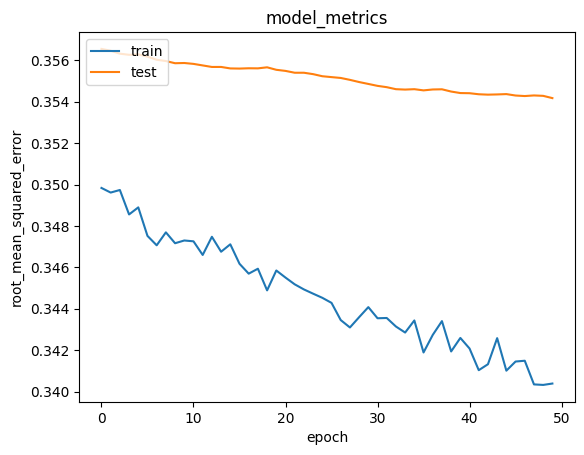

In [ ]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Memulai training


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size =32,
    epochs = 50,
    validation_data = (x_val, y_val),
)

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
class RecommenderNetV2(tf.keras.Model):
    def __init__(self, num_users, num_place, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_place = num_place
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(
            num_place,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.place_bias = layers.Embedding(num_place, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        # Combine the results
        x = dot_user_place + user_bias + place_bias
        x = tf.nn.sigmoid(x)  # Use sigmoid if your target is between 0 and 1

        # Add additional dense layers for more complexity
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)  # Dropout for regularization
        x = layers.Dense(32, activation='relu')(x)

        return x  # Return the final output (no activation for regression)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(64, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9241e-04 - root_mean_squared_error: 0.3583

/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.9215e-04 - root_mean_squared_error: 0.3582 - val_loss: 1.6856e-04 - val_root_mean_squared_error: 0.3529
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6133e-04 - root_mean_squared_error: 0.3488 - val_loss: 1.4074e-04 - val_root_mean_squared_error: 0.3512
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3446e-04 - root_mean_squared_error: 0.3482 - val_loss: 1.1661e-04 - val_root_mean_squared_error: 0.3499
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1120e-04 - root_mean_squared_error: 0.3494 - val_loss: 9.5848e-05 - val_root_mean_squared_error: 0.3490
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1218e-05 - root_mean_squared_error: 0.3467 - val_loss: 7.8116e-05 - val_root_mean_squared_error: 0.3483
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4186e-05 - root_mean_squared_error: 0.3465 - val_loss: 6.3100e-05 - val_root_mean_squared_error: 0.3479
Epoch 7/50
125/

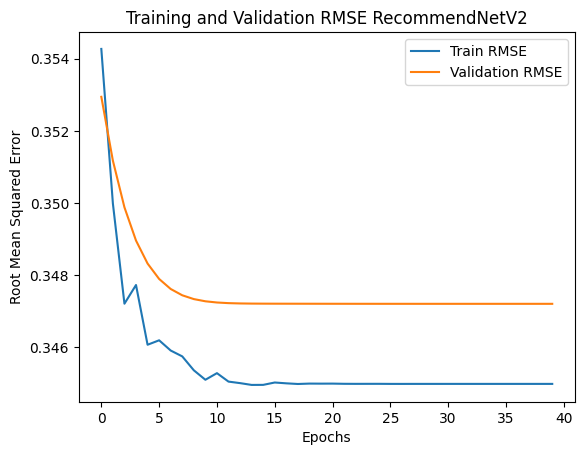

In [ ]:
# Initialize and compile the model
model = RecommenderNet(num_users, num_place, 50)

model.compile(
    #loss = tf.keras.losses.CategoricalFocalCrossentropy(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adamax(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Visualize the training and validation results
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE RecommendNetV2')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

In [138]:
data_places = place_tourism.copy()

df = rating

# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
places_visited_by_user = df[df.User_Id == user_id]

In [141]:
# Mengubah placeID menjadi list tanpa nilai yang sama
place_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan proses encoding angka ke placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

In [153]:
places_not_visited = data_places[~data_places['Place_Id'].isin(places_visited_by_user.Place_Id.values)]['Place_Id']

place_not_visited = list(set(places_not_visited).intersection(set(place_to_place_encoded.keys())))

places_not_visited = [[place_to_place_encoded.get(x)] for x in places_not_visited]

user_encoder = user_to_user_encoded.get(user_id)

user_place_array = np.hstack(([[user_encoder]] * len(places_not_visited), places_not_visited))

In [154]:
ratings = model.predict(user_place_array).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [156]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Places with high ratings from user')
print('----' * 8)

# Sort places visited by user by Place_Ratings in descending order
places_visited_by_user = places_visited_by_user.sort_values(by='Place_Ratings', ascending=False)

# Get top 5 place IDs from sorted data
top_places_user = places_visited_by_user.head(5).Place_Id.values

# Filter place_tourism (renamed to data_places) by place IDs
data_places_rows = data_places[data_places['Place_Id'].isin(top_places_user)]

# Iterate through filtered data and print place names
for row in data_places_rows.itertuples():
    print(row.Place_Name)

print('----' * 8)
print('Top 10 place recommendation')
print('----' * 8)

# Get the indices of the top 10 recommendations from the ratings array
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Get the corresponding place IDs from place_encoded_to_place
recommended_place_ids = [place_encoded_to_place.get(i) for i in top_ratings_indices] # Define recommended_place_ids

# Filter data_places by recommended_place_ids
recommended_places = data_places[data_places['Place_Id'].isin(recommended_place_ids)]

# Iterate through filtered data and print place names
for row in recommended_places.itertuples():
    print(row.Place_Name)

Showing recommendations for users: 173
Places with high ratings from user
--------------------------------
Taman Hutan Tebet
Museum Sonobudoyo Unit I
Pesona Nirwana Waterpark & Cottages
Kota Mini
Food Junction Grand Pakuwon
--------------------------------
Top 10 place recommendation
--------------------------------
Taman Pintar Yogyakarta
Taman Pelangi Yogyakarta
Bentara Budaya Yogyakarta (BBY)
Pantai Patihan
Pantai Greweng
Kampung Korea Bandung
Sanghyang Heuleut
Chingu Cafe Little Seoul
Wisata Lereng Kelir
Hutan Bambu Keputih
